## Environment Setting

In [3]:
import os
import pandas as pd
import numpy as np
import requests, traceback
from bs4 import BeautifulSoup
import datetime, time
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.mlab as mlab

# Get Daily Stock Price from Naver Finance

### Importing Stock Price Data

In [8]:
class get_stock_price:
    def __init__(self, item_name, start, end):
        self.item_name = item_name
        self.start = str(start)
        self.end = str(end)
        
    def get_company_code(self):
        code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] 
        code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) # Bring a column 'Company Code'
        code_df = code_df[['회사명', '종목코드']] # Change Korean to English 
        code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

        company_code = code_df.query("name=='{}'".format(self.item_name))['code'].to_string(index=False)
        company_code =company_code[1:]
        self.company_code = company_code
        return self.company_code
    
    
    def get_last_page(self):
        url = 'http://finance.naver.com/item/sise_day.nhn?code='+ self.company_code
        result = requests.get(url) 
        soup = BeautifulSoup(result.text, 'html.parser')

        maxPage=soup.find_all("table",align="center") 
        lp = maxPage[0].find_all("td",class_="pgRR") 
        last_page = lp[0].a.get('href').rsplit('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        self.last_page = last_page
        return self.last_page

    def parse_page(self, page):
        try:
            url = 'http://finance.naver.com/item/sise_day.nhn?code=' + self.company_code +'&page='+ str(page)
            result = requests.get(url)
            soup = BeautifulSoup(result.content, 'html.parser')
            df = pd.read_html(str(soup.find("table")), header=0)[0].dropna()   
            return df 
        except Exception as e:
            traceback.print_exc()
        return None
    
    def get_final_df(self):
        final_df = None
        for page in range(1, self.last_page+1):
            _df = self.parse_page(page)
            _df_filtered = _df[_df['날짜'] >= self.start]
            print('Crawling page #{}'.format(page))
            if final_df is None:
                final_df = _df_filtered
            else:
                final_df = pd.concat([final_df, _df_filtered])
                
            if len(_df) > len(_df_filtered) :
                print('Mission Completed')
                break
        
        final_df = final_df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff',
                                             '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
        # Change data type: to int
        final_df[['close', 'diff', 'open', 'high', 'low', 'volume']] = final_df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
        # Change data type: to date
        final_df['date'] = pd.to_datetime(final_df['date']) 
        final_df = final_df.sort_values(by=['date'], ascending=True) 
        final_df =  final_df[final_df['date'] <= self.end]
        self.final_df = final_df
        return self.final_df

    def save_to_csv(self):
        path_dir = 'data/{}-crawling'.format(datetime.datetime.strftime(datetime.datetime.today(), '%Y-%m-%d'))
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
        path = os.path.join(path_dir, '{code}_{start}_{end}.csv'.format(code=self.company_code, start=self.start, end=self.end))
        #save in csv format
        self.final_df.to_csv(path, index=False)
        print('Succesfully Saved in {}'.format(path))


In [4]:
if __name__== "__main__":
     
    item_name = 'SK'
    start = '2019-01-01'
    end = '2019-08-30'
    
    MyStock = get_stock_price(item_name=item_name, start=start, end=end)
    MyStock.get_company_code()
    MyStock.get_last_page()
    MyStock.get_final_df()
    MyStock.save_to_csv()

Crawling page #1
Crawling page #2
Crawling page #3
Crawling page #4
Crawling page #5
Crawling page #6
Crawling page #7
Crawling page #8
Crawling page #9
Crawling page #10
Crawling page #11
Crawling page #12
Crawling page #13
Crawling page #14
Crawling page #15
Crawling page #16
Crawling page #17
Crawling page #18
Mission Completed
Succesfully Saved in data/2019-09-22-crawling\034730_2019-01-01_2019-08-30.csv


# Single Asset Monte-Carlo Simulation

In [12]:
class monte_carlo:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def get_asset(self):
        df = pd.read_csv('data/2019-09-22-crawling/034730_2019-01-01_2019-08-30.csv')
        close = df['close']
        returns = close.pct_change()
        
        self.returns = returns
        self.prices = close
        
    def monte_carlo_simulation(self, num_simulation, predicted_days):
        returns = self.returns
        prices = self.prices
        
        last_price = prices.iloc[-1]
        simulation_df = pd.DataFrame()
        
        #Create each simulation as a column in df
        for x in range(num_simulation):
            count = 0 
            daily_vol = returns.std()
            
            prices_series = []
            
            #Append start value
            price = last_price * (1 + np.random.normal(0, daily_vol))
            prices_series.append(price)
            
            #Series for predicted days
            for i in range(predicted_days):
                if count == 251:
                    break
                price = prices_series[count] * (1 + np.random.normal(0, daily_vol))
                prices_series.append(price)
                count += 1
            
            simulation_df[x] = prices_series
            self.simulation_df = simulation_df
            self.predicted_days = predicted_days

    def line_graph(self):
        prices = self.prices
        predicted_days = self.predicted_days
        simulation_df = self.simulation_df
        
        last_price = prices.iloc[-1]
        fig = plt.figure(figsize=(16,8))
        style.use('bmh')
        
        title = "Monte Carlo Simulation: " + str(predicted_days) + " Days"
        plt.plot(simulation_df)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Day')
        plt.ylabel('Price (\KRW)')
        plt.annotate('Current Price: {}'.format(last_price), xy=(0, 1), xytext=(20, -20), va='top',
                     xycoords='axes fraction', textcoords='offset points')
        plt.grid(True,color='grey')
        plt.axhline(y=last_price, color='r', linestyle='-')
        plt.show()
        
    def histogram(self):
        simulation_df = self.simulation_df
        
        ser = simulation_df.iloc[-1, :]
        x = ser
        mu = ser.mean()
        sigma = ser.std()
        
        num_bins = 30
        # the histogram of the data
        n, bins, patches = plt.hist(x, num_bins, density=1, facecolor='blue', alpha=0.5)
         
        # add a 'best fit' line
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
 
        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
        plt.show()
        
    
    def VaR(self):
        simulation_df = self.simulation_df
        prices = self.prices

        last_price = prices.iloc[-1]
        
        price_array = simulation_df.iloc[-1, :]
        price_array = sorted(price_array, key=int)  
        var =  np.percentile(price_array, 1)
        
        val_at_risk = last_price - var
        print('Value at Risk: ', val_at_risk)
        
        #Histogram
        fit = stats.norm.pdf(price_array, np.mean(price_array), np.std(price_array))
        plt.plot(price_array,fit,'-o')
        plt.hist(price_array,normed=True)
        plt.xlabel('Price')
        plt.ylabel('Probability')
        plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
        plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var, 2)))
        plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: ' + str(round(last_price, 2)))
        plt.legend(loc="upper right")
        plt.show()


    def key_stats(self):
        simulation_df = self.simulation_df

        print('#------------------Simulation Stats------------------#')
        count = 1
        for column in simulation_df:
            print("Simulation", count, "Mean Price: ", simulation_df[column].mean())
            print("Simulation", count, "Median Price: ", simulation_df[column].median() )
            count += 1
        
        print('\n')
        
        print('#----------------------Last Price Stats--------------------#')
        print("Mean Price: ", np.mean(simulation_df.iloc[-1,:]))
        print("Maximum Price: ",np.max(simulation_df.iloc[-1,:]))
        print("Minimum Price: ", np.min(simulation_df.iloc[-1,:]))
        print("Standard Deviation: ",np.std(simulation_df.iloc[-1,:]))

        print('\n')
       
        print('#----------------------Descriptive Stats-------------------#')
        price_array = simulation_df.iloc[-1, :]
        print(price_array.describe())
        print('\n')
               
        print('#--------------Annual Expected Returns for Trials-----------#')
        count = 1
        future_returns = simulation_df.pct_change()
        for column in future_returns:
            print("Simulation", count, "Annual Expected Return", "{0:.2f}%".format((future_returns[column].mean() * 252) * 100))
            print("Simulation", count, "Total Return", "{0:.2f}%".format((future_returns[column].iloc[1] / future_returns[column].iloc[-1] - 1) * 100))
            count += 1     

        print('\n')
                         
        #Create Column For Average Daily Price Across All Trials
        simulation_df['Average'] = simulation_df.mean(axis=1)
        ser = simulation_df['Average']
        
        print('#----------------------Percentiles--------------------------------#')
        percentile_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
        for per in percentile_list:
            print("{}th Percentile: ".format(per), np.percentile(price_array, per))
        
        print('\n')

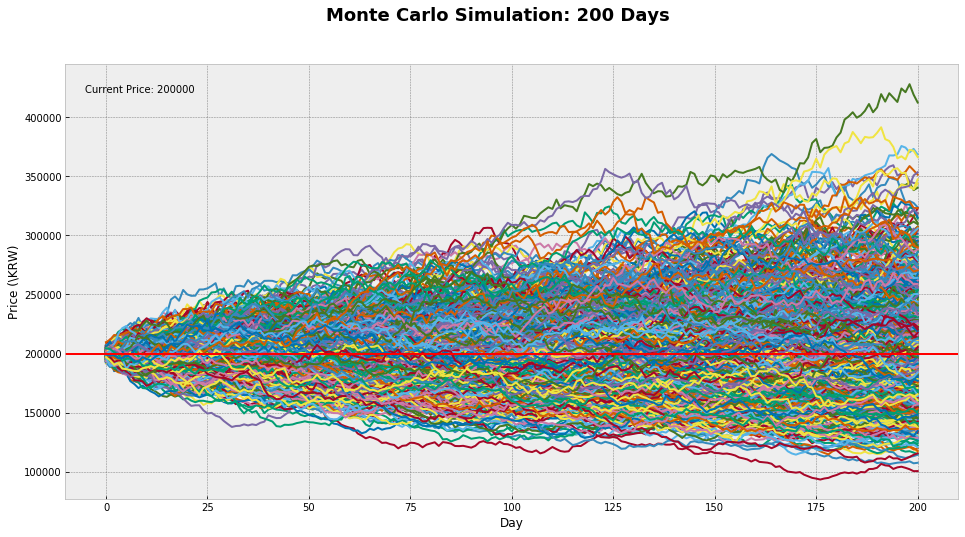

C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


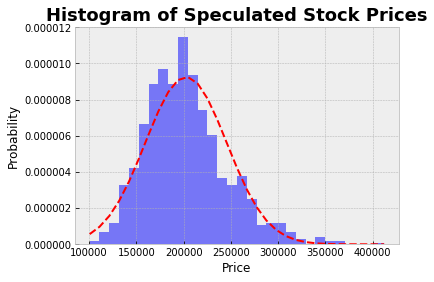

Value at Risk:  75839.25211211557


C:\Users\josep\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


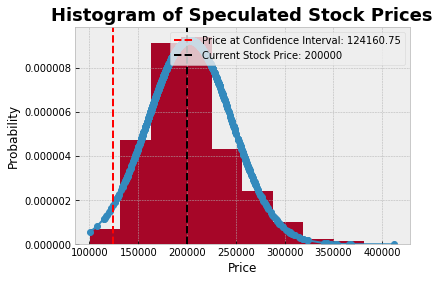

#------------------Simulation Stats------------------#
Simulation 1 Mean Price:  179802.1199437376
Simulation 1 Median Price:  181560.53614904496
Simulation 2 Mean Price:  205260.38235514952
Simulation 2 Median Price:  204281.02659813943
Simulation 3 Mean Price:  277376.1013208336
Simulation 3 Median Price:  266407.7580403541
Simulation 4 Mean Price:  211453.50356242267
Simulation 4 Median Price:  214795.18465947395
Simulation 5 Mean Price:  199920.25503747858
Simulation 5 Median Price:  202846.958287259
Simulation 6 Mean Price:  175471.63724402545
Simulation 6 Median Price:  174605.7987830349
Simulation 7 Mean Price:  164932.05815664347
Simulation 7 Median Price:  167418.99291087795
Simulation 8 Mean Price:  205806.38192163932
Simulation 8 Median Price:  203507.78294802335
Simulation 9 Mean Price:  195596.07179104487
Simulation 9 Median Price:  199639.06363998426
Simulation 10 Mean Price:  191861.46218990083
Simulation 10 Median Price:  191162.2729633073
Simulation 11 Mean Price:  251

Simulation 126 Median Price:  175921.39721252865
Simulation 127 Mean Price:  203255.4643956232
Simulation 127 Median Price:  204250.06681369556
Simulation 128 Mean Price:  181801.71481849212
Simulation 128 Median Price:  182352.4146684962
Simulation 129 Mean Price:  180336.53454180594
Simulation 129 Median Price:  181996.91334486628
Simulation 130 Mean Price:  179377.93800126304
Simulation 130 Median Price:  174918.54431809828
Simulation 131 Mean Price:  177513.13497370775
Simulation 131 Median Price:  178004.69136448033
Simulation 132 Mean Price:  257858.20578752164
Simulation 132 Median Price:  263049.11142115947
Simulation 133 Mean Price:  210484.28030624433
Simulation 133 Median Price:  210547.40553196982
Simulation 134 Mean Price:  213132.51346683572
Simulation 134 Median Price:  217368.5059372391
Simulation 135 Mean Price:  186773.3832291241
Simulation 135 Median Price:  186420.7419862516
Simulation 136 Mean Price:  213465.38557835782
Simulation 136 Median Price:  209149.52489814

Simulation 229 Mean Price:  204289.90660735007
Simulation 229 Median Price:  200668.96597041903
Simulation 230 Mean Price:  167360.0751106188
Simulation 230 Median Price:  162161.39576778468
Simulation 231 Mean Price:  183079.64904353768
Simulation 231 Median Price:  181856.02827096518
Simulation 232 Mean Price:  169574.4272685096
Simulation 232 Median Price:  165509.4167970147
Simulation 233 Mean Price:  213090.08495717047
Simulation 233 Median Price:  211453.2642464062
Simulation 234 Mean Price:  202742.09572942302
Simulation 234 Median Price:  203695.3823957002
Simulation 235 Mean Price:  216580.35196510848
Simulation 235 Median Price:  216155.9995516187
Simulation 236 Mean Price:  224022.56317895648
Simulation 236 Median Price:  224563.57861149288
Simulation 237 Mean Price:  188054.34149709152
Simulation 237 Median Price:  187797.75754996025
Simulation 238 Mean Price:  182723.51177701922
Simulation 238 Median Price:  181351.2276468489
Simulation 239 Mean Price:  162107.3845409573
S

Simulation 317 Median Price:  204871.35584648605
Simulation 318 Mean Price:  192358.52608517907
Simulation 318 Median Price:  192487.50281667066
Simulation 319 Mean Price:  237141.33931273394
Simulation 319 Median Price:  237482.41224527682
Simulation 320 Mean Price:  182202.39053075688
Simulation 320 Median Price:  184482.99250881444
Simulation 321 Mean Price:  186872.55657695248
Simulation 321 Median Price:  188308.68758227135
Simulation 322 Mean Price:  222051.08428281665
Simulation 322 Median Price:  219771.71473036066
Simulation 323 Mean Price:  179199.24500946514
Simulation 323 Median Price:  184766.73503952578
Simulation 324 Mean Price:  181079.232634574
Simulation 324 Median Price:  181903.03431861923
Simulation 325 Mean Price:  244755.4898879168
Simulation 325 Median Price:  245226.30653528273
Simulation 326 Mean Price:  225192.11001871055
Simulation 326 Median Price:  228556.4151214488
Simulation 327 Mean Price:  202840.27272395315
Simulation 327 Median Price:  199559.1407546

Simulation 411 Mean Price:  236172.45724448777
Simulation 411 Median Price:  235269.2788118058
Simulation 412 Mean Price:  190561.58769801704
Simulation 412 Median Price:  189550.90632592788
Simulation 413 Mean Price:  170581.7230403637
Simulation 413 Median Price:  167910.64920120657
Simulation 414 Mean Price:  204484.55131726485
Simulation 414 Median Price:  204391.02766082343
Simulation 415 Mean Price:  207518.78228915486
Simulation 415 Median Price:  206421.91730143852
Simulation 416 Mean Price:  209486.16106853678
Simulation 416 Median Price:  210137.8174102995
Simulation 417 Mean Price:  217290.31091694633
Simulation 417 Median Price:  217885.37474537155
Simulation 418 Mean Price:  154817.98566322168
Simulation 418 Median Price:  145355.60272325086
Simulation 419 Mean Price:  179254.33191451745
Simulation 419 Median Price:  181817.81245978738
Simulation 420 Mean Price:  175056.83268106217
Simulation 420 Median Price:  176123.3242621741
Simulation 421 Mean Price:  180091.287966042

Simulation 507 Mean Price:  209488.73437128728
Simulation 507 Median Price:  207733.6485356193
Simulation 508 Mean Price:  179492.8528755132
Simulation 508 Median Price:  182437.9251095933
Simulation 509 Mean Price:  206307.50367988844
Simulation 509 Median Price:  211891.32994848563
Simulation 510 Mean Price:  246952.67823454048
Simulation 510 Median Price:  237763.67846533933
Simulation 511 Mean Price:  205367.7029645606
Simulation 511 Median Price:  206593.660011505
Simulation 512 Mean Price:  197804.71741706805
Simulation 512 Median Price:  196190.65008005625
Simulation 513 Mean Price:  188311.06660656794
Simulation 513 Median Price:  188028.3195924043
Simulation 514 Mean Price:  177720.55142921288
Simulation 514 Median Price:  176459.74530733493
Simulation 515 Mean Price:  227450.2232035481
Simulation 515 Median Price:  224293.29143978062
Simulation 516 Mean Price:  205766.66657507865
Simulation 516 Median Price:  202970.64664106554
Simulation 517 Mean Price:  180391.92175270437
S

Simulation 600 Mean Price:  200852.6710965674
Simulation 600 Median Price:  200774.3409990482
Simulation 601 Mean Price:  167817.72851124086
Simulation 601 Median Price:  165243.09236114463
Simulation 602 Mean Price:  200124.3668268587
Simulation 602 Median Price:  197827.64397823674
Simulation 603 Mean Price:  174296.73118289185
Simulation 603 Median Price:  168979.69539346435
Simulation 604 Mean Price:  197130.85207387616
Simulation 604 Median Price:  194623.98712445883
Simulation 605 Mean Price:  235549.31370783324
Simulation 605 Median Price:  236295.88762523624
Simulation 606 Mean Price:  223315.93854403053
Simulation 606 Median Price:  225047.21072771092
Simulation 607 Mean Price:  220095.30637895924
Simulation 607 Median Price:  221781.0720527792
Simulation 608 Mean Price:  226437.67121629827
Simulation 608 Median Price:  227864.00970590304
Simulation 609 Mean Price:  188332.95306393164
Simulation 609 Median Price:  187521.57895178872
Simulation 610 Mean Price:  161536.733760634

Simulation 695 Median Price:  210710.61551638116
Simulation 696 Mean Price:  218052.66441855597
Simulation 696 Median Price:  219267.7228623791
Simulation 697 Mean Price:  227197.03510297133
Simulation 697 Median Price:  231487.66560927816
Simulation 698 Mean Price:  167393.03704714982
Simulation 698 Median Price:  167578.77124981486
Simulation 699 Mean Price:  184295.00831821508
Simulation 699 Median Price:  182779.5572517302
Simulation 700 Mean Price:  173188.123347865
Simulation 700 Median Price:  178209.61634573486
Simulation 701 Mean Price:  208818.6723450314
Simulation 701 Median Price:  209077.07727710888
Simulation 702 Mean Price:  214253.08860796728
Simulation 702 Median Price:  212327.16514586404
Simulation 703 Mean Price:  190391.87712933501
Simulation 703 Median Price:  193896.60812638173
Simulation 704 Mean Price:  213354.02899935664
Simulation 704 Median Price:  192855.3340024847
Simulation 705 Mean Price:  198981.1377194238
Simulation 705 Median Price:  197213.1624018261

Simulation 868 Median Price:  179347.7874020327
Simulation 869 Mean Price:  192159.03343287448
Simulation 869 Median Price:  192774.867029637
Simulation 870 Mean Price:  191104.74665148085
Simulation 870 Median Price:  184314.06525159342
Simulation 871 Mean Price:  203575.97892877652
Simulation 871 Median Price:  203395.16412162507
Simulation 872 Mean Price:  228701.81326636058
Simulation 872 Median Price:  229127.3776351587
Simulation 873 Mean Price:  231775.46332073704
Simulation 873 Median Price:  232001.62837347668
Simulation 874 Mean Price:  220109.682378605
Simulation 874 Median Price:  219823.57992901324
Simulation 875 Mean Price:  180989.89268991
Simulation 875 Median Price:  179795.48786510434
Simulation 876 Mean Price:  200446.68761510093
Simulation 876 Median Price:  200490.14171019872
Simulation 877 Mean Price:  146087.1432349441
Simulation 877 Median Price:  142582.25585570955
Simulation 878 Mean Price:  261222.3900305007
Simulation 878 Median Price:  273663.0658566747
Sim

Simulation 965 Mean Price:  185817.8344067174
Simulation 965 Median Price:  189442.35075376218
Simulation 966 Mean Price:  154684.10194741024
Simulation 966 Median Price:  145892.96635012075
Simulation 967 Mean Price:  213862.42668768394
Simulation 967 Median Price:  213084.51765678547
Simulation 968 Mean Price:  176729.0507332188
Simulation 968 Median Price:  174817.71874378328
Simulation 969 Mean Price:  188832.86772095875
Simulation 969 Median Price:  188040.20612889284
Simulation 970 Mean Price:  156594.117436106
Simulation 970 Median Price:  146619.60668556605
Simulation 971 Mean Price:  213492.61981257997
Simulation 971 Median Price:  212166.18994910902
Simulation 972 Mean Price:  197552.82545449203
Simulation 972 Median Price:  195013.17271030723
Simulation 973 Mean Price:  210905.5449775322
Simulation 973 Median Price:  207793.67241703952
Simulation 974 Mean Price:  226011.05972761867
Simulation 974 Median Price:  228637.2344811221
Simulation 975 Mean Price:  206335.17068962133

Simulation 104 Annual Expected Return -12.57%
Simulation 104 Total Return -262.38%
Simulation 105 Annual Expected Return -4.30%
Simulation 105 Total Return 103.16%
Simulation 106 Annual Expected Return 60.79%
Simulation 106 Total Return 75.72%
Simulation 107 Annual Expected Return -28.59%
Simulation 107 Total Return -247.24%
Simulation 108 Annual Expected Return 3.90%
Simulation 108 Total Return 47.35%
Simulation 109 Annual Expected Return -19.21%
Simulation 109 Total Return -182.90%
Simulation 110 Annual Expected Return 25.80%
Simulation 110 Total Return -471.47%
Simulation 111 Annual Expected Return 29.65%
Simulation 111 Total Return -179.81%
Simulation 112 Annual Expected Return -19.70%
Simulation 112 Total Return -358.90%
Simulation 113 Annual Expected Return 7.90%
Simulation 113 Total Return 1021.07%
Simulation 114 Annual Expected Return -3.70%
Simulation 114 Total Return -136.05%
Simulation 115 Annual Expected Return 7.61%
Simulation 115 Total Return -56.04%
Simulation 116 Annual

Simulation 259 Annual Expected Return 2.49%
Simulation 259 Total Return 17.37%
Simulation 260 Annual Expected Return -19.93%
Simulation 260 Total Return -350.46%
Simulation 261 Annual Expected Return 9.21%
Simulation 261 Total Return -866.21%
Simulation 262 Annual Expected Return -12.47%
Simulation 262 Total Return 239.46%
Simulation 263 Annual Expected Return -34.79%
Simulation 263 Total Return -29.02%
Simulation 264 Annual Expected Return 11.58%
Simulation 264 Total Return 309.50%
Simulation 265 Annual Expected Return 4.48%
Simulation 265 Total Return -55.31%
Simulation 266 Annual Expected Return 13.40%
Simulation 266 Total Return -469.13%
Simulation 267 Annual Expected Return 5.34%
Simulation 267 Total Return -149.92%
Simulation 268 Annual Expected Return -10.54%
Simulation 268 Total Return 35.81%
Simulation 269 Annual Expected Return 16.55%
Simulation 269 Total Return -82.21%
Simulation 270 Annual Expected Return 14.08%
Simulation 270 Total Return 102.33%
Simulation 271 Annual Expe

Simulation 428 Annual Expected Return -13.41%
Simulation 428 Total Return -23.44%
Simulation 429 Annual Expected Return -18.79%
Simulation 429 Total Return -43.65%
Simulation 430 Annual Expected Return 0.03%
Simulation 430 Total Return -194.00%
Simulation 431 Annual Expected Return -15.84%
Simulation 431 Total Return -135.58%
Simulation 432 Annual Expected Return 12.29%
Simulation 432 Total Return -267.53%
Simulation 433 Annual Expected Return 11.93%
Simulation 433 Total Return 282.19%
Simulation 434 Annual Expected Return -13.62%
Simulation 434 Total Return 279.55%
Simulation 435 Annual Expected Return 17.02%
Simulation 435 Total Return -110.14%
Simulation 436 Annual Expected Return -19.74%
Simulation 436 Total Return 35.68%
Simulation 437 Annual Expected Return -9.64%
Simulation 437 Total Return 41.27%
Simulation 438 Annual Expected Return 45.06%
Simulation 438 Total Return 1681.34%
Simulation 439 Annual Expected Return -35.45%
Simulation 439 Total Return 94.55%
Simulation 440 Annual

Simulation 584 Total Return -100.28%
Simulation 585 Annual Expected Return 56.60%
Simulation 585 Total Return -133.39%
Simulation 586 Annual Expected Return -26.85%
Simulation 586 Total Return -53.68%
Simulation 587 Annual Expected Return -22.42%
Simulation 587 Total Return -76.48%
Simulation 588 Annual Expected Return 26.62%
Simulation 588 Total Return 18.79%
Simulation 589 Annual Expected Return 15.50%
Simulation 589 Total Return -105.41%
Simulation 590 Annual Expected Return -26.58%
Simulation 590 Total Return -152.06%
Simulation 591 Annual Expected Return -0.76%
Simulation 591 Total Return -130.78%
Simulation 592 Annual Expected Return -18.28%
Simulation 592 Total Return 120.08%
Simulation 593 Annual Expected Return 5.23%
Simulation 593 Total Return 170.03%
Simulation 594 Annual Expected Return 22.68%
Simulation 594 Total Return -1735.99%
Simulation 595 Annual Expected Return 2.06%
Simulation 595 Total Return -175.01%
Simulation 596 Annual Expected Return 2.42%
Simulation 596 Total

Simulation 740 Total Return 50.46%
Simulation 741 Annual Expected Return -26.24%
Simulation 741 Total Return 50.08%
Simulation 742 Annual Expected Return 4.52%
Simulation 742 Total Return -128.18%
Simulation 743 Annual Expected Return -30.47%
Simulation 743 Total Return -447.29%
Simulation 744 Annual Expected Return -37.14%
Simulation 744 Total Return -157.85%
Simulation 745 Annual Expected Return -3.13%
Simulation 745 Total Return -103.15%
Simulation 746 Annual Expected Return -3.37%
Simulation 746 Total Return -1863.86%
Simulation 747 Annual Expected Return -10.58%
Simulation 747 Total Return -98.66%
Simulation 748 Annual Expected Return 36.24%
Simulation 748 Total Return -1578.74%
Simulation 749 Annual Expected Return -2.12%
Simulation 749 Total Return 1018.27%
Simulation 750 Annual Expected Return 13.74%
Simulation 750 Total Return -203.95%
Simulation 751 Annual Expected Return 1.09%
Simulation 751 Total Return -366.22%
Simulation 752 Annual Expected Return 7.95%
Simulation 752 Tot

Simulation 930 Total Return 15.72%
Simulation 931 Annual Expected Return -65.79%
Simulation 931 Total Return -113.44%
Simulation 932 Annual Expected Return 12.97%
Simulation 932 Total Return -11.86%
Simulation 933 Annual Expected Return 5.67%
Simulation 933 Total Return -35.66%
Simulation 934 Annual Expected Return 0.74%
Simulation 934 Total Return -235.30%
Simulation 935 Annual Expected Return -1.58%
Simulation 935 Total Return -176.63%
Simulation 936 Annual Expected Return -5.17%
Simulation 936 Total Return 62.34%
Simulation 937 Annual Expected Return -49.26%
Simulation 937 Total Return -172.54%
Simulation 938 Annual Expected Return 12.38%
Simulation 938 Total Return 150.63%
Simulation 939 Annual Expected Return -37.14%
Simulation 939 Total Return 271.58%
Simulation 940 Annual Expected Return 32.80%
Simulation 940 Total Return -243.56%
Simulation 941 Annual Expected Return 24.91%
Simulation 941 Total Return 50.56%
Simulation 942 Annual Expected Return 11.60%
Simulation 942 Total Retu

In [13]:
if __name__== "__main__":

    start = datetime.datetime(2019, 1, 1)
    end = datetime.datetime(2019, 8, 1)
    
    sim = monte_carlo(start=start, end=end)

    sim.get_asset()
    sim.monte_carlo_simulation(1000, 200)
    sim.line_graph()
    sim.histogram()
    sim.VaR()
    sim.key_stats()

### End